# Setup Libraries and Load Input Data

Importing data sets

In [1]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib
import rasterio
from rasterio.plot import show, show_hist, reshape_as_raster, reshape_as_image

%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

data_dir = os.chdir("C:\\_geodata\\scripts\\forest_analysis\\data")

# Read satellite imagery stack
img_ds = gdal.Open('stack.tif', gdal.GA_ReadOnly)
# Read training data as raster 
roi_ds = gdal.Open('training_data.tif', gdal.GA_ReadOnly)

In [2]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint16)

# Visualize Input Data

Visualize data

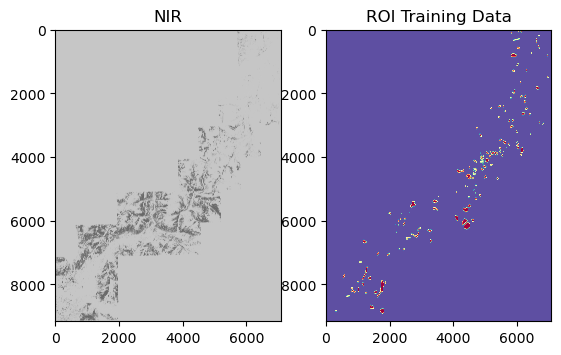

In [3]:
# Display them
plt.subplot(121)
plt.imshow(img[:,:,4], cmap=plt.cm.Greys)
plt.title('NIR')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

# Reshape Input Data for ML Algorithm

Clip input images to extent of training data

In [4]:
num_columns_roi = roi.shape[1]
num_columns_img = img.shape[1]

if num_columns_roi == num_columns_img:
    print("The number of columns in roi and img match.")
else:
    print("The number of columns in roi and img do not match.")
    print("Number of columns in roi:", num_columns_roi)
    print("Number of columns in img:", num_columns_img)

The number of columns in roi and img match.


In [5]:
# Training data pixel are 1 (forest) 0 (non-forest) no data is 32767 due to int16 data structure
n_samples = (roi < 2).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi < 2])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

X = img[roi < 2, :]
y = roi[roi < 2]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))
print('Observations of forest: {sz}'.format(sz = np.count_nonzero(y == 1)))
print('Observations of non-forest: {sz}'.format(sz = np.count_nonzero(y == 0)))

We have 548305 samples
The training data include 2 classes: [0 1]
Our X matrix is sized: (548305, 7)
Our y array is sized: (548305,)
Observations of forest: 272236
Observations of non-forest: 276069


Split training data in training and testing data sets

In [6]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=109) 
# 50% testing and 50% training
print('Our X train matrix is sized: {sz}'.format(sz=X_train.shape))
print('Our y train array is sized: {sz}'.format(sz=y_train.shape))
print('Our X test matrix is sized: {sz}'.format(sz=X_test.shape))
print('Our y test array is sized: {sz}'.format(sz=y_test.shape))

Our X train matrix is sized: (274152, 7)
Our y train array is sized: (274152,)
Our X test matrix is sized: (274153, 7)
Our y test array is sized: (274153,)


Check the pixel count for each landcover class in the training data

In [7]:
#Check whether training sample is balanced across class levels
print(np.unique(y_train))
print('Observations of class 1: {sz}'.format(sz = np.count_nonzero(y_train == 0)))
print('Observations of class 2: {sz}'.format(sz = np.count_nonzero(y_train == 1)))
# These classes are not used with for a binary forest classification
#print('Observations of class 3: {sz}'.format(sz = np.count_nonzero(y_train == 3)))
#print('Observations of class 4: {sz}'.format(sz = np.count_nonzero(y_train == 4)))
#print('Observations of class 5: {sz}'.format(sz = np.count_nonzero(y_train == 5)))
#print('Observations of class 6: {sz}'.format(sz = np.count_nonzero(y_train == 6)))

[0 1]
Observations of class 1: 137817
Observations of class 2: 136335


# Model Parameter Search Grid

This was adapted from a tutorial at https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb

For better results with my data it may be worth looking into alternative parameters in the 'param grid' setting. 

In [8]:
RSEED = 50
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = 60, 
                        scoring = 'accuracy', cv = 5, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=60,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['sqrt', None, 0.5, 0.6,
                                                         0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12, ...],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, 192, 196, 200])},
                   random_state=50, scoring='accuracy', verbose=1)

In [9]:
print(rs.best_params_)
rf_best = rs.best_estimator_

{'n_estimators': 29, 'min_samples_split': 5, 'max_leaf_nodes': 43, 'max_features': 0.7, 'max_depth': 17, 'bootstrap': True}


In [10]:
print(rf_best.feature_importances_)
print(rf_best.get_params)

[5.77502927e-02 2.49048616e-01 4.50990435e-01 2.36792440e-01
 3.21397353e-05 4.51576445e-03 8.70312036e-04]
<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=17, max_features=0.7, max_leaf_nodes=43,
                       min_samples_split=5, n_estimators=29, random_state=50)>


Feature ranking:
1. feature 2 (0.450990)
2. feature 1 (0.249049)
3. feature 3 (0.236792)
4. feature 0 (0.057750)
5. feature 5 (0.004516)
6. feature 6 (0.000870)
7. feature 4 (0.000032)


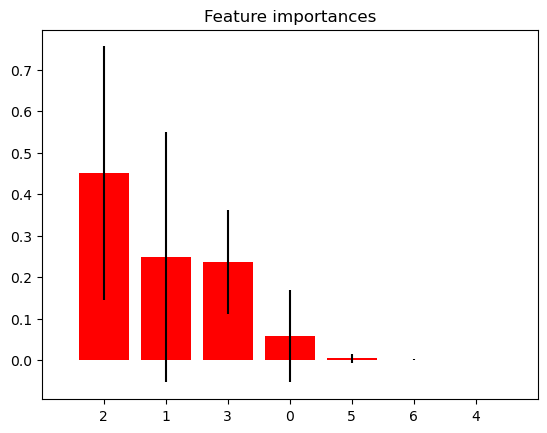

In [11]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [12]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Predict the response for test dataset
y_best = rf_best.predict(X_test)

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
#predicted probabilities from model
rf_probs = rf_best.predict_proba(X_test)
print(rf_probs[1])
print(rf_probs.shape)
#keep positive results
rf_probs1 = rf_probs[:, 1]
#compute AUROC
rf_auc = roc_auc_score(y_test, rf_probs1)
print('Random Forest: AUROC = %.3f' % (rf_auc))

[0.00619893 0.99380107]
(274153, 2)
Random Forest: AUROC = 0.995


In [14]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_best))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_best, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_best, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("AUC:",metrics.roc_auc_score(y_test, rf_probs1))

Accuracy: 0.9730150682283251
Precision: 0.9730700878100732
Recall: 0.9730150682283251
AUC: 0.995338745639567


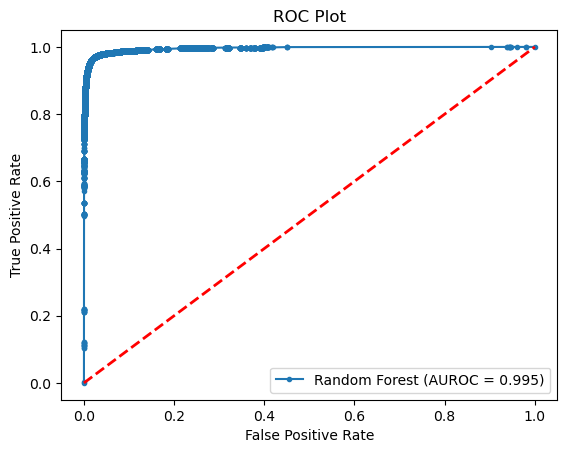

In [15]:
import matplotlib.pyplot as plt
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs1)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
# Show legend
plt.legend() # 
# Show plot
plt.show()

Save best model for predicting future images

In [16]:
import joblib
filename = 'REv1_RFv2.sav'
joblib.dump(rf_best, filename)

['REv1_RFv2.sav']

Load saved model to predict images

In [17]:
import joblib
filename = 'REv1_RFv2.sav'
rf_best = joblib.load(filename)

# Predict Full Image Tile

Reshape full image tile to 2D array, predict with RF model, reshape back to 3D image array

In [18]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img[:, :, :].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

Reshaped from (9155, 7076, 7) to (64780780, 7)


In [19]:
# Now predict for each pixel
class_prediction = rf_best.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Plot image tile classification results

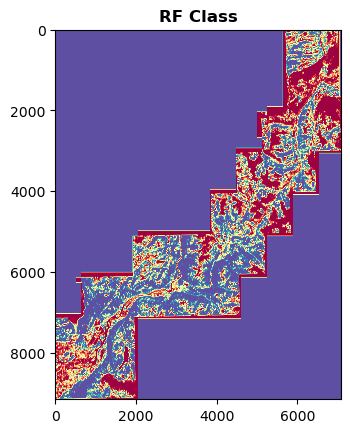

<Axes: title={'center': 'RF Class'}>

In [20]:
rasterio.plot.show(class_prediction, cmap='Spectral', title='RF Class')

Change classification data class to Uint16 to save storage space

In [21]:
class_u16 = class_prediction.astype('uint16')
print(class_u16.dtype)

uint16


Save classification image to folder

# Export Classification

In [25]:
#Load original image to get transform for output geometry
from rasterio.crs import CRS

img_fp = 'stack.tif'
dataset = rasterio.open(img_fp)
class_out = rasterio.open(
    'forestmask.tif',
    'w',
    driver='GTiff',
    height=class_prediction.shape[0],
    width=class_prediction.shape[1],
    count=1,
    dtype=class_prediction.dtype,
    crs='+proj=latlong',
    transform=dataset.transform)

In [26]:
class_out.write(class_prediction, 1)
class_out.close()